In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten , Convolution2D, MaxPooling2D , Lambda, Conv2D, Activation,Concatenate, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam , SGD , Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers , initializers, activations
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt
import corner
import os 
import sys
import time
import importlib
import logging
from tqdm import tqdm

importlib.reload(logging)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=20000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [2]:
%%time
training_data = np.load("./nsi_data/sample_nsi_regression_1e7_v1.npz")
data_all = np.column_stack([training_data['ve_dune'][:,:36], training_data['vu_dune'][:,:36], training_data['vebar_dune'][:,:36], training_data['vubar_dune'][:,:36]])

target = np.column_stack([training_data["theta23"], training_data["delta"]/180*np.pi])

x_train = data_all[:90]
y_train = target[:90]
y_train_angle = np.column_stack([y_train[:,0], np.sin(y_train[:,1]), np.cos(y_train[:,1])]) 

# x_test = data_all[9000000:]
# y_test = target[9000000:]
# y_test_angle = np.column_stack([y_test[:,0], np.sin(y_test[:,1]), np.cos(y_test[:,1])]) 

x_train_poisson = np.random.poisson(x_train)/1000
# x_test_poisson = np.random.poisson(x_test)/1000

CPU times: user 21.2 s, sys: 6.45 s, total: 27.6 s
Wall time: 28 s


In [11]:
path = './CVAE/DNN_angleTran_allparam_30g_{}'.format(1)
gaussian_number = 30
encoder1 = load_model(path + "/encoder_1_test_v2.h5", compile=False)
encoder2 = load_model(path + "/encoder_2_test_v2.h5", compile=False)
decoder = load_model(path + "/decoder_test_v2.h5", compile=False)

In [15]:
%%time
n = 1
data_poisson_array = x_train[n:n+1]/1000

mean, log_var, weight = encoder2.predict(data_poisson_array)

mean = tf.reshape(mean, (-1, gaussian_number, 7))
log_var = tf.reshape(log_var, (-1, gaussian_number, 7))
weight = tf.reshape(weight, (-1, gaussian_number))

SMALL_CONSTANT = 1e-12
temp_var = SMALL_CONSTANT + tf.exp(log_var)
test_sampling = tfp.distributions.MixtureSameFamily(
              mixture_distribution=tfp.distributions.Categorical(logits=weight),
              components_distribution=tfp.distributions.MultivariateNormalDiag(
              loc=mean,
              scale_diag=tf.sqrt(temp_var)))

sample_amount= 1000000
prediction = []

Z3 = np.reshape(test_sampling.sample(sample_shape=(sample_amount)), (sample_amount, 30))
target_array = np.reshape([data_poisson_array for i in range(sample_amount)], (sample_amount, 144))
reconstruction_mean, reconstruction_var = decoder.predict([Z3, target_array])
temp_var = SMALL_CONSTANT + tf.exp(reconstruction_var)
reconstruction_parameter = tfp.distributions.MultivariateNormalDiag(
                         loc=reconstruction_mean,
                         scale_diag= tf.sqrt(temp_var))
prediction = reconstruction_parameter.sample().numpy()

prediction = np.array(prediction)
logging.info(prediction.shape)

CPU times: user 51.8 s, sys: 7.01 s, total: 58.9 s
Wall time: 35 s


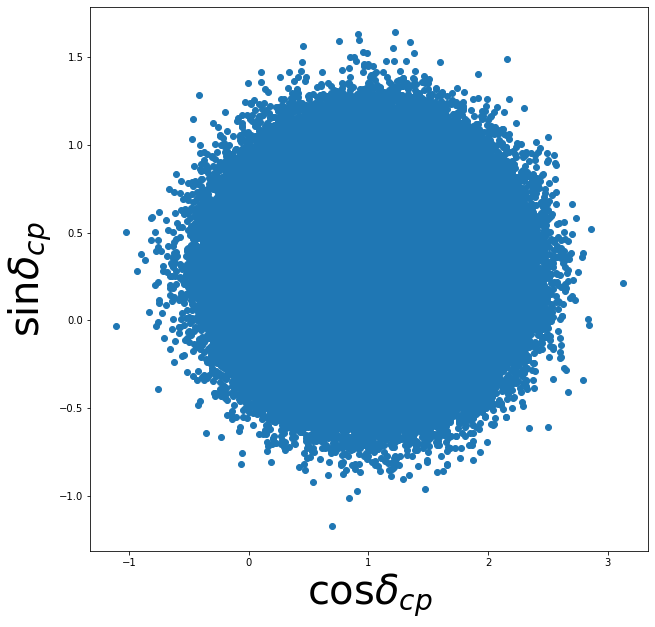

In [17]:
plt.figure(figsize=(10,10))
plt.scatter(prediction[:, 3], prediction[:, 2])
plt.xlabel('cos$\delta_{cp}$', fontsize = 40)
plt.ylabel('sin$\delta_{cp}$', fontsize = 40)
plt.savefig('./graph/tmp')
plt.show()

In [19]:
degree = np.angle(prediction[:,3] + 1j*np.array(prediction[:,2]), deg=True)
degree = [d if d > 0 else 360+d for d in degree]
prediction2 = np.column_stack([prediction[:,:2], degree, prediction[:, 4:]])

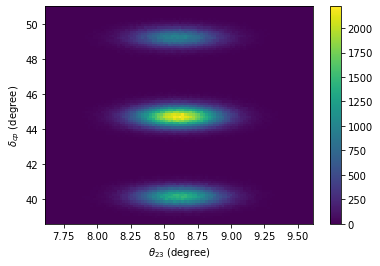

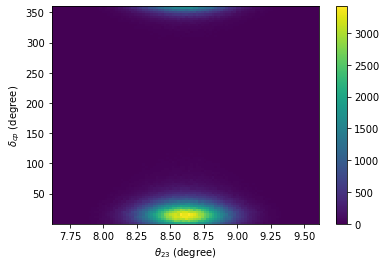

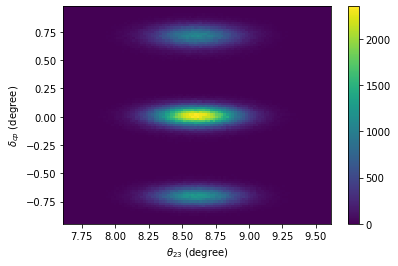

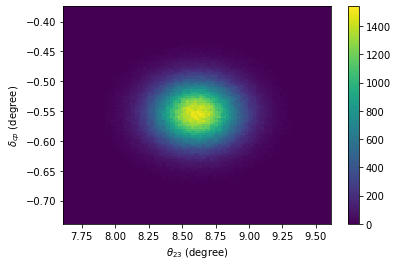

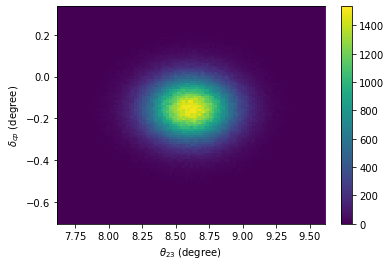

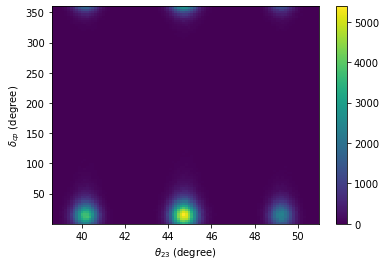

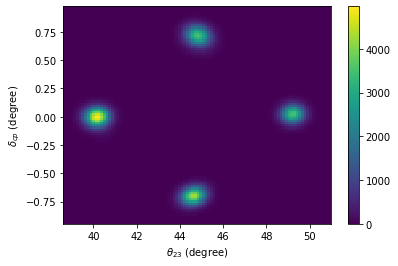

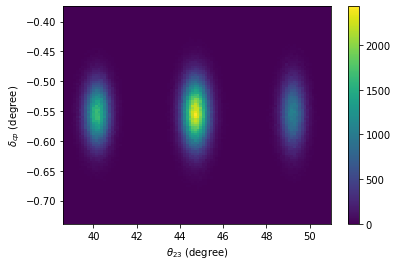

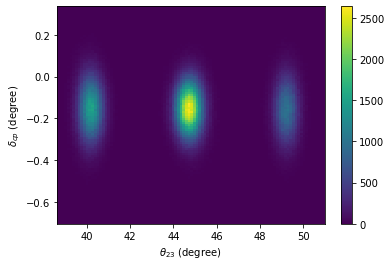

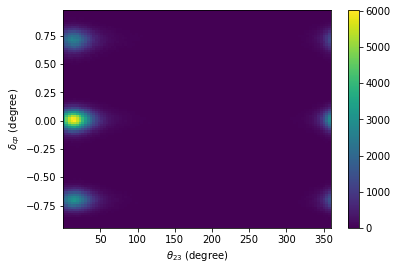

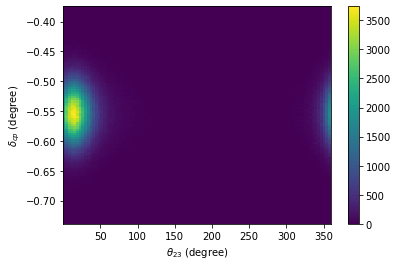

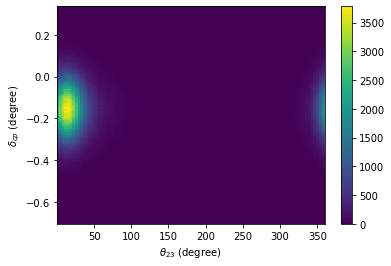

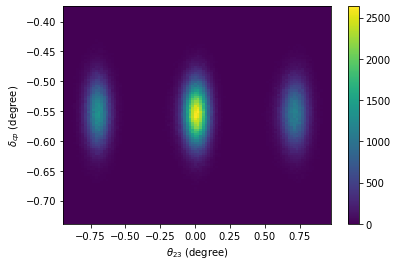

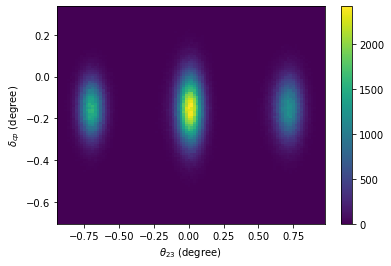

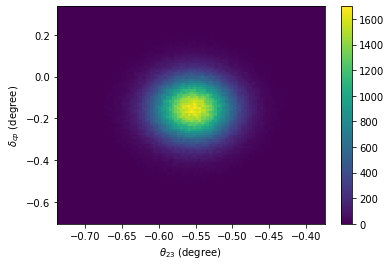

In [22]:
for i in range(len(prediction2[0])):
    for j in range(i+1, len(prediction2[0])):
        plt.hist2d(prediction2[:,i], prediction2[:,j], bins = 100)
        plt.xlabel('$\\theta_{23}$ (degree)')
        plt.ylabel('$\delta_{cp}$ (degree)')
        plt.colorbar()
        plt.savefig('tmp')
        plt.show()

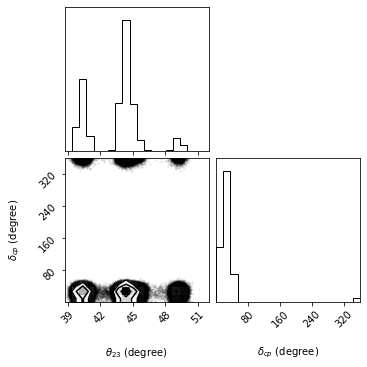

In [29]:
figure = corner.corner(prediction2, labels=["$\\theta_{23}$ (degree)", "$\delta_{cp}$ (degree)"])

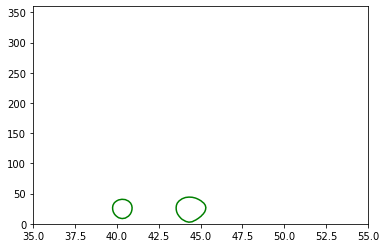

In [30]:
corner.hist2d(prediction2[:, 0], prediction2[:, 1],
                    levels=(0.68,),
                    scale_hist=True,
                    plot_datapoints=False,
                    color='green',
                    labels= ["$\\theta_{23} $($^\circ$)", "$\delta_{cp} $($^\circ$)"],
                    range=[[35,55], [0, 360]],
                    plot_contours = True,
                    plot_density = False,
                    fontsize=30,
                    bins = [100, 100],
                    label_kwargs={"fontsize": 30},
                    smooth=True
                   )

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp2d, RectBivariateSpline

In [32]:
def plot_graph(x, y, c, i, name):
    plt.scatter(x, y, c=c)
    plt.colorbar()
    plt.title('data{}_chi-square value'.format(i))
    plt.xlabel('$\\theta_{23}$ (degree)')
    plt.ylabel('$\delta_{cp}$ (degree)')
    plt.clim(0,)
    plt.savefig('./graph/data '.format(i) + name)
    plt.show()

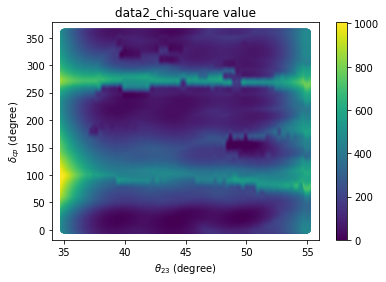

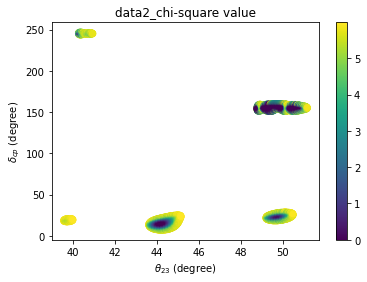

In [42]:
for i in range(n+1, n+2):
    a = np.loadtxt('./chi_theta23_delta_contour/chi_theta23_delta_v{}.dat'.format(i))
    arr = list(zip(*a))
    x0 = sorted(set(arr[0]))
    y0 = sorted(set(arr[1]))
    z0 = np.reshape(arr[2], (81, 37))
    f = RectBivariateSpline(x0, y0, z0)
    xnew = np.linspace(35, 55, 1000)
    ynew = np.linspace(0, 360, 1000)
    znew = f(xnew, ynew)
    mx, my = np.meshgrid(ynew, xnew)
    x = np.reshape(mx, 1000000)
    y = np.reshape(my, 1000000)
    z = np.reshape(znew, 1000000)
    plot_graph(y, x, z, i , 'chi-square value_full (RectBivariateSpline)')
    loc = np.where(z < 5.99)
    plot_graph(y[loc], x[loc], z[loc], i, 'chi-square value_two_sigma (RectBivariateSpline)')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'label'


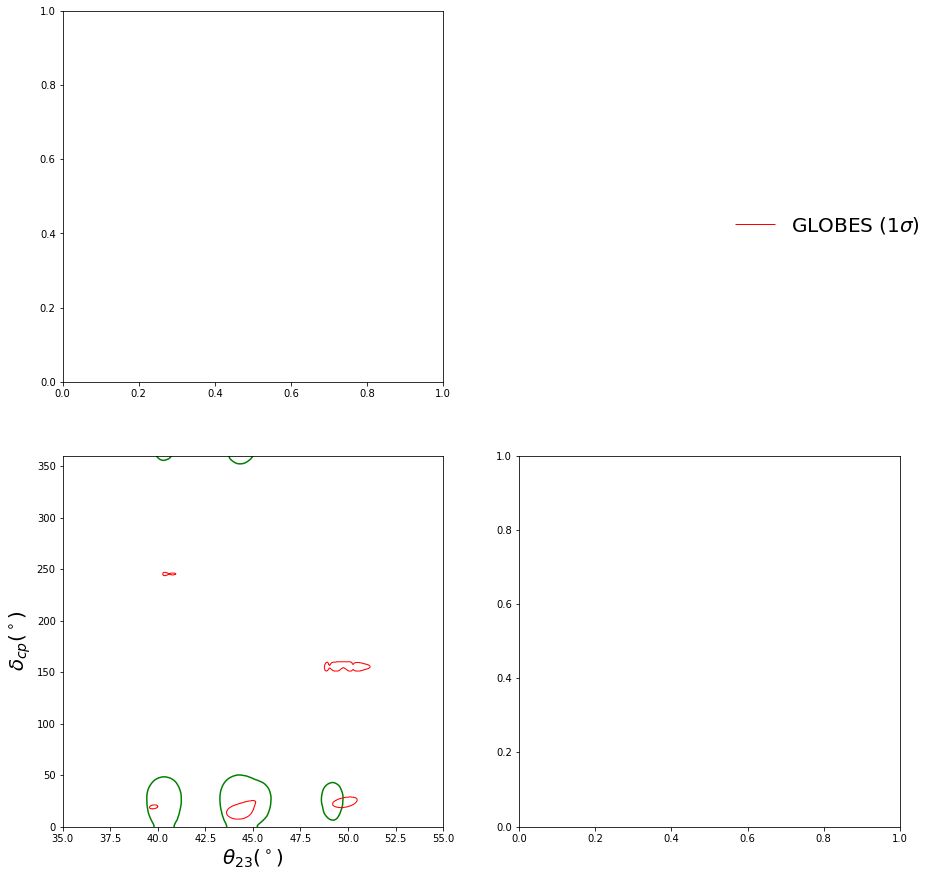

In [43]:
fig, ax = plt.subplots(1,1, figsize=(15,15))
plot_axis = plt.subplot(2,2,1)
plot_axis = plt.subplot(2,2,4)
plot_axis = plt.subplot(2,2,3)
r1 = corner.hist2d(prediction2[:, 0], prediction2[:, 1],
                    levels=(0.95,),
                    scale_hist=True,
                    plot_datapoints=False,
                    color='green',
                    labels= ["$\\theta_{23} $($^\circ$)", "$\delta_{cp} $($^\circ$)"],
                    range=[[35,55], [0, 360]],
                    plot_contours = True,
                    plot_density = False,
                    fontsize=30,
                    bins = [200, 200],
                    label_kwargs={"fontsize": 30},
                    smooth=True
                   )
one_sigma_region_boundary = np.where(znew > 5.99, 1, 0 )
r2 = CS_1_sigma = plot_axis.contour(xnew, ynew, one_sigma_region_boundary.T, 0, colors='red', linestyles="-", linewidths=1, label = 'Prediction')
plot_axis.set_xlabel("$\\theta_{23} $($^\circ$)", fontsize = 20)
plot_axis.set_ylabel("$\delta_{cp} $($^\circ$)", fontsize = 20)
# r1.collections[0].set_label("Prediction")
r2.collections[0].set_label("GLOBES (1$\sigma$)")
plt.legend(bbox_to_anchor=(2.3, 1.7), ncol=1,fontsize=20, markerscale=4, edgecolor = "w",fancybox=False, framealpha=0)
plt.show()